## Fetal Immune Atlas - save labels in anndata

In this notebook I load the raw merged anndata file and add the labels unified in `20201230_UniformCellLabels.ipynb`, fixing some inconsistencies on cell names between organs.

In [1]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
from bbknn import bbknn
import scipy

## For geosketch integration
from geosketch import gs, uniform, srs, kmeanspp
from scanorama import transform
from scipy.sparse import csr_matrix, find
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
# from subprocess import Popen
# import sys
from time import time
from datetime import datetime

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Load merged dataset 

In [2]:
merged_raw = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
merged_raw.obs['batch'] = [x+y for x,y in zip(merged_raw.obs['organ'],merged_raw.obs['method'])]
merged_raw.obs['bbk'] = [x+y for x,y in zip(merged_raw.obs['donor'],merged_raw.obs['method'])]

Change barcodes for gut cells

In [4]:
def _rename_gut_cells(x):
    if "FCA" not in x:
        x = x.split("_")[8].split('-')[1] + "-1"  + "_" + "_".join(x.split("_")[3:6])
    else: 
        x = x.split("_")[7].split('-')[1] + "-1" + "_" + "_".join(x.split("_")[3:5]) 
    return(x)

In [5]:
obs_names = merged_raw.obs_names.values
gut_ixs = np.where(merged_raw.obs.organ=="GU")[0]
for i in gut_ixs:
    obs_names[i] = _rename_gut_cells(obs_names[i])

In [6]:
merged_raw.obs_names = obs_names

### Add cell type labels

Made uniform in `notebooks/20201230_UniformCellLabels.ipynb`

In [7]:
annot_dir = '/home/jovyan/mount/gdrive/Pan_fetal/annotations/'
annot_df = pd.read_csv(annot_dir + "uniform_labels_full.csv", index_col=0)

In [9]:
# ### WARNING!! There are duplicated indices in the skin dataset, here I am solving the brute force way
# annot_df.loc[annot_df.index[annot_df.index.duplicated(keep=False)],'uniform_label'] = "NEUTROPHIL"
# annot_df.loc[annot_df.index[annot_df.index.duplicated(keep=False)],'cell.labels'] = "Neutrophile"

# annot_df = annot_df[~annot_df.index.duplicated()]

Fix names to make them uniform w dataset

In [10]:
def _translate_obs_names(x, organ):
    if organ in ["sp", 'bm']:
        if "FCA" in x:
            obs_name = x.split("_")[3]+ '-' +x.split("_")[5]
        else:
            obs_name = x
    elif organ in ["ki"]:
        if "FCA" in x:
            obs_name = x.split("_")[0] + "-" + x.split("_")[-1].split('-')[0]
        else:
            obs_name = x
    elif organ in ["li", 'ys']:
        obs_name = x.split("_")[3]+'-'+x.split("_")[4]
    elif organ in ["sk"]:
        obs_name = x.split("-")[2]+'-'+x.split("-")[0]
    elif organ in ["gu"]:
        obs_name = "-".join(x.split("-")[:2]) + "_" + x.split("-")[2]
    else:
        obs_name = x
    return(obs_name)

In [11]:
# annot_df.index = annot_df["old_name"]
annot_df.index = ["GEX".join(x.split("prime")) for x in annot_df.index]
new_name = [_translate_obs_names(annot_df.index[i],annot_df.organ[i]) for i in range(annot_df.shape[0])]

In [12]:
annot_df["old_name"] = annot_df.index
annot_df.index = new_name

In [13]:
## Subset to cells in the adata
annot_df = annot_df.loc[merged_raw.obs_names[merged_raw.obs_names.isin(annot_df.index)]]

In [14]:
new_anno = pd.concat([merged_raw.obs, annot_df[['uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0']]], 1)

In [16]:
merged_raw.obs = new_anno[~new_anno.Sample.isna()].loc[merged_raw.obs_names]

## Add correct metadata

In [18]:
metadata = pd.read_csv("/home/jovyan/mount/gdrive/Pan_fetal/annotations/manifest_clean_120121.csv", index_col=0)

In [19]:
metadata['method'] = [x.split("prime")[0]+"GEX" if "prime" in x else x for x in metadata["Sequencing"]]

## Rename columns as they are in obs
metadata['donor'] = metadata['SAMPLE.NAME']

In [20]:
clean_metadata = metadata[["Sample.lanes", "Sort_id","age", "method", "donor", "sex", "Processing_method"]]
clean_metadata["file"] = clean_metadata['Sample.lanes']

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
new_obs = merged_raw.obs.reset_index().merge(clean_metadata, on=['file', "donor", "method"], how='left', indicator=True)
new_obs = new_obs.set_index("index")

## Check that the merge has worked properly
if not new_obs.shape[0] == merged_raw.obs.shape[0]:
    print("--- WARNING!! The new obs has more rows than the old obs ---")

if np.any(new_obs._merge=="right_only"):
    print("--- WARNING!! Some values are unique to metadata ---")

if not new_obs.index.is_unique:
    print("--- WARNING!! Duplicate indices ---")
    


In [22]:
new_obs = new_obs.drop(["sort", "_merge"],1)

In [24]:
new_obs.to_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.full_obs.csv")

---
## Visualizing experimental design

In [8]:
%load_ext rpy2.ipython

In [9]:
%%R
library(tidyverse)
library(ggplot2)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
new_obs = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.full_obs.csv')

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10,17,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
donor_count = new_obs.reset_index()[["organ", "donor", "index"]].groupby(["donor", "organ"]).count().reset_index()


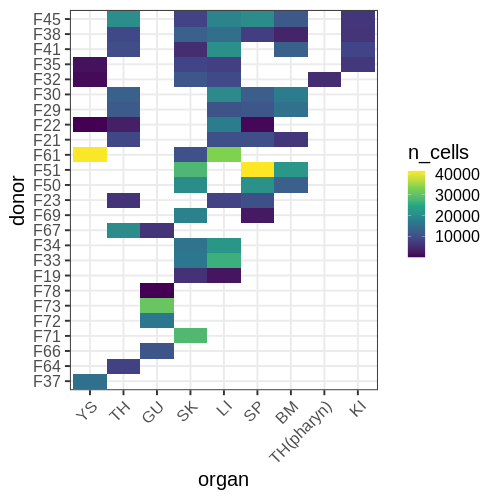

In [53]:
%%R -i donor_count -w 500 -h 500

donor_count %>%
rename(n_cells=index) %>%
group_by(donor) %>%
mutate(n_organs=n()) %>%
ungroup() %>%
arrange(n_organs) %>%
mutate(donor = factor(donor, levels=unique(donor))) %>%
mutate(organ = factor(organ, levels=unique(organ))) %>%
ggplot(aes(organ, donor, fill=n_cells)) +
geom_tile() +
theme_bw(base_size=20) +
theme(axis.text.x=element_text(angle=45, hjust=1)) +
scale_fill_viridis_c()

In [65]:
new_obs["Sample"]

218

In [66]:
age_count = new_obs.reset_index()[["Sample", "organ", "donor", 'age',"index"]].groupby(["Sample", "donor", "organ", 'age']).count().reset_index()


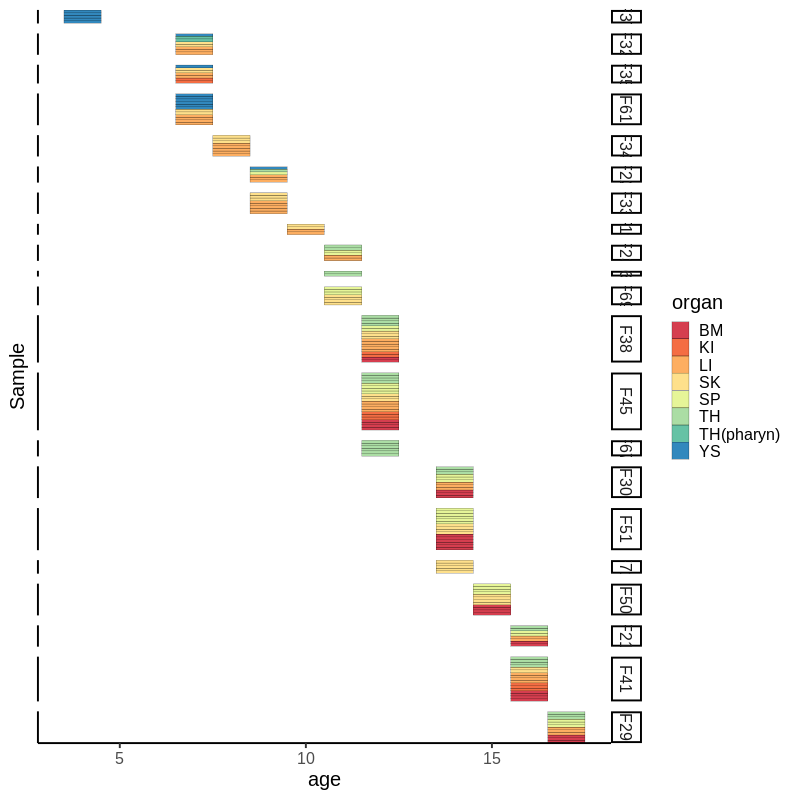

In [105]:
%%R -i age_count -w 800 -h 800

age_count %>%
rename(n_cells=index) %>%
arrange(age, donor, organ) %>%
mutate(donor = factor(donor, levels=unique(donor))) %>%
mutate(Sample = factor(Sample, levels=unique(Sample))) %>%
# mutate(organ = factor(organ, levels=unique(organ))) %>%
ggplot(aes(age, Sample, fill=organ)) +
geom_tile(color='black') +
theme_classic(base_size=20) +
scale_fill_brewer(palette="Spectral") +
theme(axis.text.y=element_blank(), axis.ticks.y=element_blank()) +
facet_grid(donor~., scales="free", space="free")


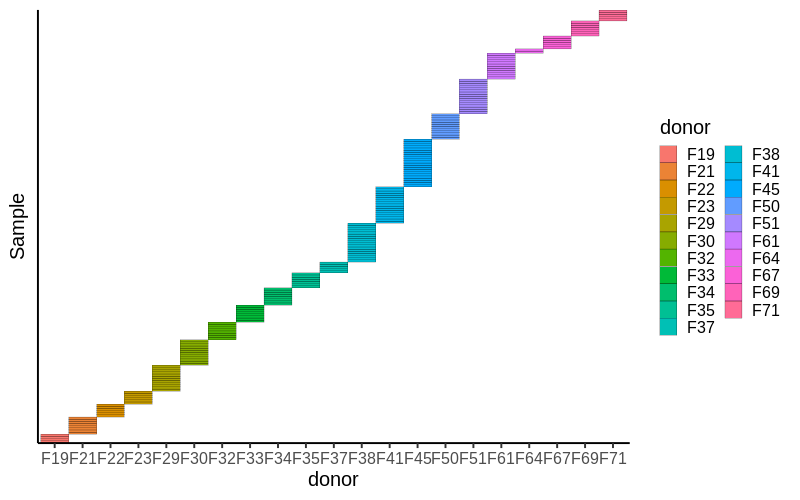

In [96]:
%%R -i age_count -w 800 -h 500

age_count %>%
rename(n_cells=index) %>%
arrange(donor, organ) %>%
# mutate(donor = factor(donor, levels=unique(donor))) %>%
mutate(Sample = factor(Sample, levels=unique(Sample))) %>%
# mutate(organ = factor(organ, levels=unique(organ))) %>%
ggplot(aes(donor, Sample, fill=donor)) +
geom_tile(color='black') +
theme_classic(base_size=20) +
theme(axis.text.y=element_blank(), axis.ticks.y=element_blank())  


In [106]:
merged_raw

NameError: name 'merged_raw' is not defined